In [ ]:
import tensorflow as tf

print('TensorFlow Version:', tf.__version__)
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))
print('GPU Device:', tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.18.0
Num GPUs Available: 1
GPU Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ndvi_data_path = '/content/drive/My Drive/DEPI/Data/Processed_Data/NDVI'

In [ ]:
# %pip install sklearn

In [ ]:
os.listdir(ndvi_data_path)

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
data_dir = ndvi_data_path

classes = sorted(os.listdir(data_dir))
print("Found classes:", classes)

X = []
y = []

for idx, cls in enumerate(classes):
    cls_folder = os.path.join(data_dir, cls)
    for file in os.listdir(cls_folder):
        if file.endswith('.npy'):
            file_path = os.path.join(cls_folder, file)
            arr = np.load(file_path)

            if len(arr.shape) == 2:
                arr = arr[..., np.newaxis]
            X.append(arr)
            y.append(idx)

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} samples with shape {X.shape}")


Found classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Loaded 26861 samples with shape (26861, 64, 64, 1)


In [ ]:
num_classes = len(classes)
y_cat = to_categorical(y, num_classes)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")



Training samples: 21488, Validation samples: 5373


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [ ]:
input_shape = X_train.shape[1:]

model_ndvi = Sequential([
    Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


model_ndvi.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_ndvi.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,225,162 (8.49 MB)

 Trainable params: 2,224,714 (8.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model_ndvi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.4881 - loss: 1.8054 - val_accuracy: 0.1126 - val_loss: 28.6639
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6754 - loss: 0.9834 - val_accuracy: 0.6000 - val_loss: 1.0634
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7209 - loss: 0.8461 - val_accuracy: 0.6173 - val_loss: 1.1107
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7615 - loss: 0.7102 - val_accuracy: 0.5771 - val_loss: 1.1964
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7893 - loss: 0.6153 - val_accuracy: 0.6151 - val_loss: 1.0078
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8089 - loss: 0.5664 - val_accuracy: 0.5667 - val_loss: 1.9622
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8278 - loss: 0.5099 - val_accuracy: 0.8009 - val_loss: 0.6168
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8394 - loss: 0.4838 - val_ac

In [ ]:
print("\nEvaluating the model:")
loss, accuracy = model_ndvi.evaluate(X_val, y_val, batch_size=24)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Evaluating the model:
224/224 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8549 - loss: 0.4753
Validation Loss: 0.4613
Validation Accuracy: 0.8571


168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


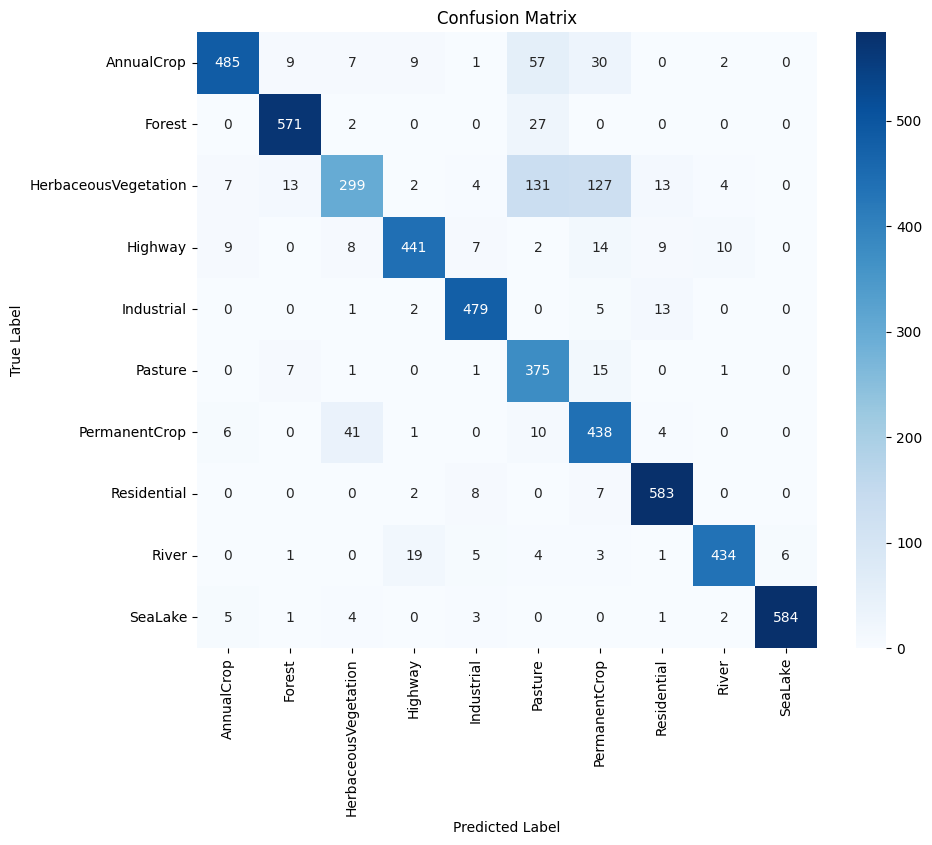

In [ ]:
y_pred_proba = model_ndvi.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_ndvi = Sequential([
    Conv2D(32, (3, 3), input_shape=(64, 64, 1), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model_ndvi.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model_ndvi.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             

 Total params: 2,328,586 (8.88 MB)

 Trainable params: 2,326,090 (8.87 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [ ]:
history = model_ndvi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.5894 - loss: 1.2920 - val_accuracy: 0.2626 - val_loss: 4.2431
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7749 - loss: 0.6899 - val_accuracy: 0.7192 - val_loss: 0.8156
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8202 - loss: 0.5455 - val_accuracy: 0.6615 - val_loss: 1.1929
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8432 - loss: 0.4834 - val_accuracy: 0.7108 - val_loss: 0.7614
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8629 - loss: 0.4277 - val_accuracy: 0.7908 - val_loss: 0.5841
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8734 - loss: 0.3942 - val_accuracy: 0.8118 - val_loss: 0.5407
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8938 - loss: 0.3471 - val_accuracy: 0.7486 - val_loss: 0.8943
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9049 - loss: 0.2845 - val_

In [ ]:

print("\nEvaluating the model:")
loss, accuracy = model_ndvi.evaluate(X_val, y_val, batch_size=24)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")



Evaluating the model:
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8965 - loss: 0.3616
Validation Loss: 0.3342
Validation Accuracy: 0.9015


In [ ]:
model_ndvi.save('model_NDVI_v0.h5')

168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


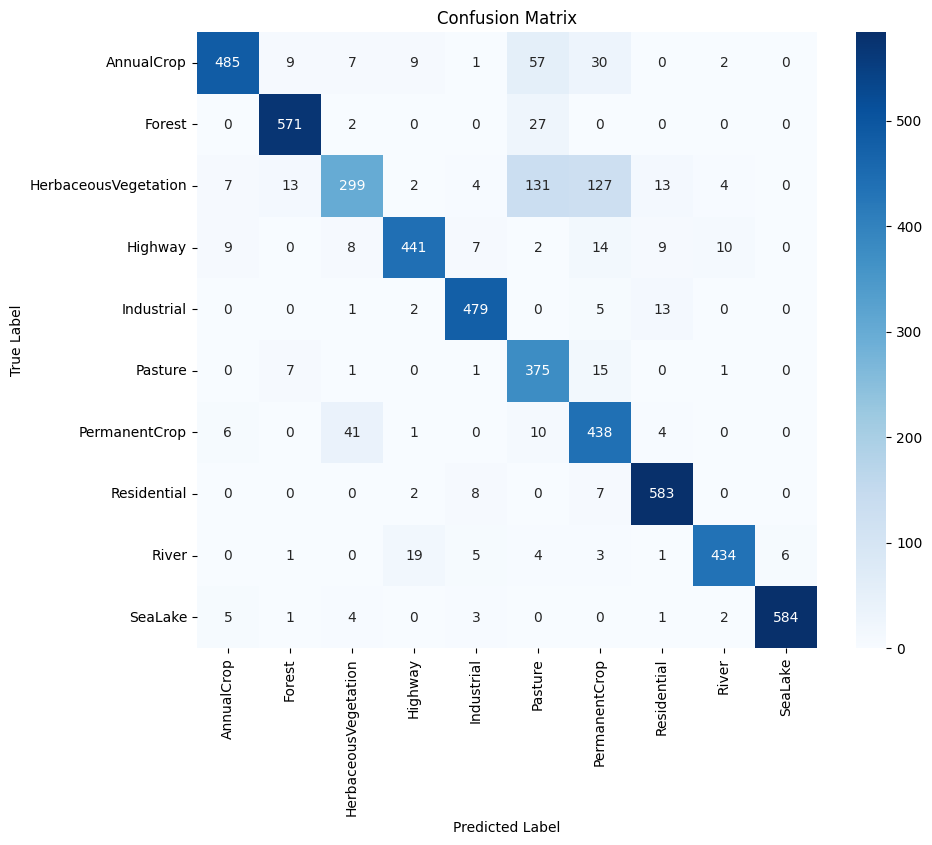

In [ ]:
y_pred_proba = model_ndvi.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_ndvi = Sequential([
    Conv2D(32, (3, 3), input_shape=(64, 64, 1), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'), # Added layer
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    # Removed one MaxPooling2D here

    Conv2D(1024, (3, 3), activation='relu', padding='same'), # Added layer
    BatchNormalization(),
    # Removed another MaxPooling2D here

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])
model_ndvi.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_ndvi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 31s 54ms/step - accuracy: 0.6123 - loss: 1.3327 - val_accuracy: 0.2321 - val_loss: 3.1301
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.7696 - loss: 0.7157 - val_accuracy: 0.3754 - val_loss: 5.7944
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8143 - loss: 0.5816 - val_accuracy: 0.7169 - val_loss: 0.9218
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8469 - loss: 0.4956 - val_accuracy: 0.6719 - val_loss: 1.4774
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8499 - loss: 0.4560 - val_accuracy: 0.7540 - val_loss: 1.1708
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8686 - loss: 0.3978 - val_accuracy: 0.6951 - val_loss: 1.0020
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.8883 - loss: 0.3408 - val_accuracy: 0.7703 - val_loss: 0.8877
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8362 - loss: 0.7297 - val

In [ ]:
%pip install matplotlib

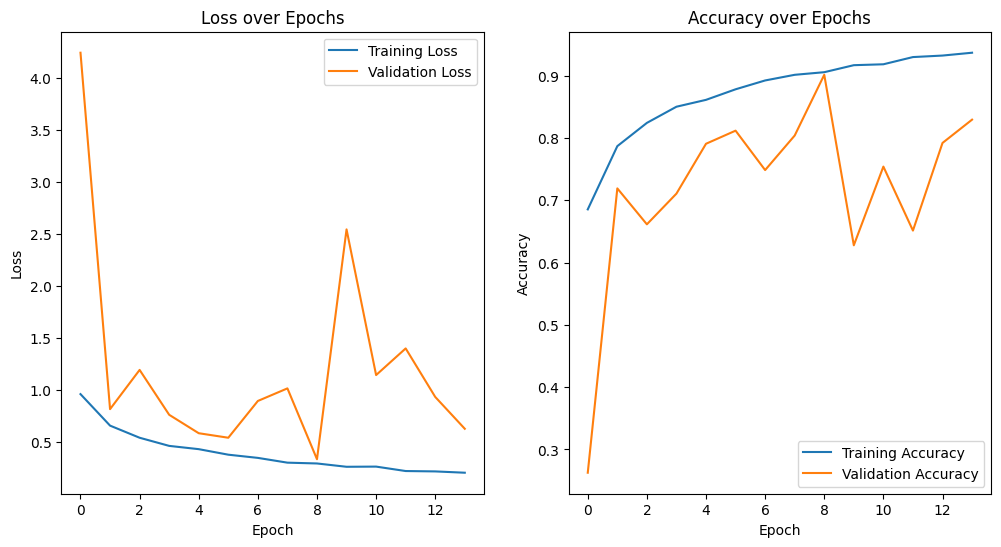

In [ ]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model_ndvi.save('model_NDVI_v1.h5')

168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


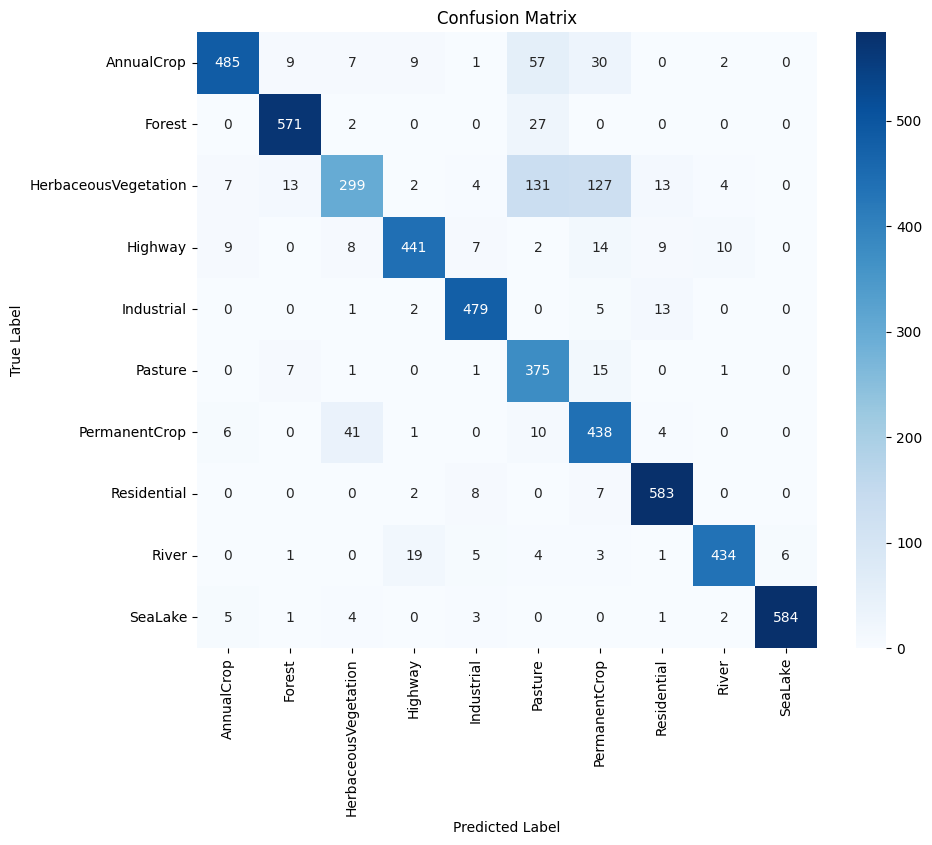

In [ ]:
y_pred_proba = model_ndvi.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_ndvi = Sequential([
    Conv2D(32, (3, 3), input_shape=(64, 64, 1), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

In [ ]:
model_ndvi.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model_ndvi.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 50s 68ms/step - accuracy: 0.5258 - loss: 1.6677 - val_accuracy: 0.2191 - val_loss: 8.5873
Epoch 2/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7336 - loss: 0.7880 - val_accuracy: 0.6998 - val_loss: 0.7611
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7852 - loss: 0.6383 - val_accuracy: 0.5749 - val_loss: 1.8215
Epoch 4/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8153 - loss: 0.5486 - val_accuracy: 0.7458 - val_loss: 0.7466
Epoch 5/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8481 - loss: 0.4789 - val_accuracy: 0.7681 - val_loss: 0.6546
Epoch 6/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8596 - loss: 0.4392 - val_accuracy: 0.8118 - val_loss: 0.5762
Epoch 7/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8695 - loss: 0.4099 - val_accuracy: 0.7882 - val_loss: 0.7448
Epoch 8/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8811 - loss: 0.3836 - 

In [ ]:
print("\nEvaluating the model:")
loss, accuracy = model_ndvi.evaluate(X_val, y_val, batch_size=24)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Evaluating the model:
224/224 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8658 - loss: 0.4218
Validation Loss: 0.4253
Validation Accuracy: 0.8615


168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


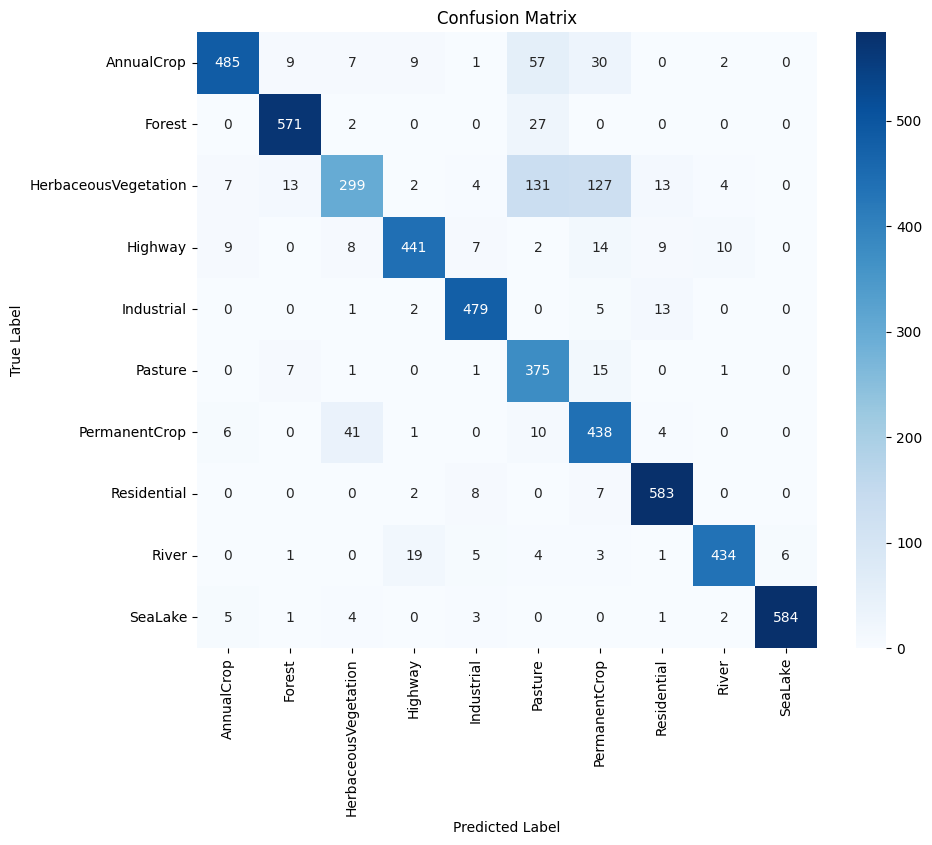

In [ ]:
y_pred_proba = model_ndvi.predict(X_val)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

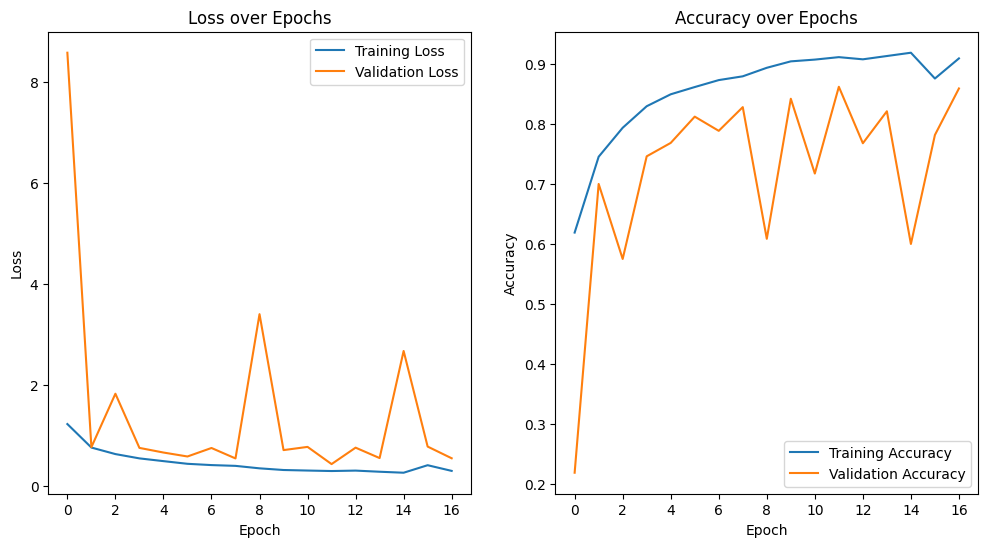

In [ ]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model_ndvi.save('model_NDVI_v2.h5')